In [1]:
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import numpy
from torch.utils.data import Dataset
import random,pandas

In [2]:
# check if CUDA is available
# if yes, set default tensor type to cuda

if torch.cuda.is_available():
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
  print("using cuda:", torch.cuda.get_device_name(0))
  pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

using cuda: NVIDIA GeForce GTX 1650


device(type='cuda')

In [3]:
# modified from https://github.com/pytorch/vision/issues/720
#将三维图像张量重塑成一个长度为218*178*3的一维张量
class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape,

    def forward(self, x):
        return x.view(*self.shape)

In [4]:
class MnistDataset(Dataset):
    def __init__(self,csv_file):
        self.data_df=pd.read_csv(csv_file,header=None)
        pass
    #获取数据集大小
    def __len__(self):
        return len(self.data_df)
    #通过索引获取项目
    def __getitem__(self, index):
        #目标图像(label)
        label=self.data_df.iloc[index,0]
        target=torch.zeros((10)) #[1,0,0,0,0,0,0,0,0,0,0]独热码
        target[label]=1.0
        #图像数据,取值范围是0-255，标准化至0-1
        image_values=torch.cuda.FloatTensor(self.data_df.iloc[index,1:].values)/255.0
        #返回label+图像数据张量+目标张量
        return label,image_values,target
    def plot_image(self,index):
        arr=self.data_df.iloc[index,1:].values.reshape(28,28)
        plt.title('label='+str(self.data_df.iloc[index,0]))
        plt.imshow(arr,interpolation='none',cmap='Blues')
        plt.show()
        pass
    pass

        

In [5]:
mnist_dataset=MnistDataset(r'D:\py\mnist_data\mnist_train.csv')

In [6]:
# functions to generate random data
#均匀抽取，适用鉴别器
def generate_random_image(size):
    random_data = torch.rand(size)
    return random_data

#正态抽取,均值为0，方差为1，适用分类器
def generate_random_seed(size):
    random_data = torch.randn(size)
    return random_data

In [74]:
#鉴别器
class Discriminator(nn.Module):
    def __init__(self):
        #初始化父类
        super().__init__()
        self.model=nn.Sequential(
            nn.Linear(784,200),
            nn.LeakyReLU(0.02),
            nn.LayerNorm(200),
            nn.Linear(200,1),
            nn.Sigmoid()
        )
        #loss
        self.loss_function=nn.BCELoss()
        #优化器
        self.optimiser=torch.optim.Adam(self.parameters(),lr=0.0001)
        #计数器&progress
        self.counter=0
        self.progress=[]
        pass
    #调用模型
    def forward(self,inputs):
        return self.model(inputs)
    #训练模型
    def train(self,inputs,targets):
        #计算网络输出
        outputs=self.forward(inputs)
        #计算损失值
        loss=self.loss_function(outputs,targets)
        #10次增加计数器
        self.counter+=1
        if (self.counter%10==0):
            self.progress.append(loss.item())
            pass
        if(self.counter%10000==0):
            print('counter=',self.counter)
            pass
        #归零梯度，反向传播，更新权重
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()
        pass
    
    #绘图
    def plot_progress(self):
        df=pd.DataFrame(self.progress,columns=['loss']) #损失值转换为DF
        df.plot(ylim=(0),figsize=(16,8),alpha=0.1,marker='.',grid=True,yticks=(0,0.25,0.5,1.0,5.0))
        pass

counter= 10000
counter= 20000
counter= 30000
counter= 40000
counter= 50000
counter= 60000
counter= 70000
counter= 80000
counter= 90000
counter= 100000
counter= 110000
counter= 120000


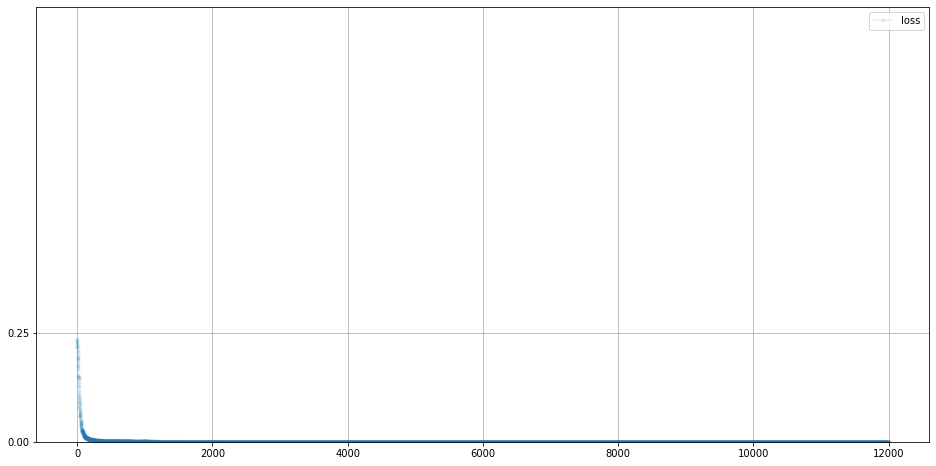

In [48]:
%%time
#训练
D=Discriminator()
#使用cuda
D.to(device)
for label,image_data_tensor,target_tensor in mnist_dataset:
    #真实
    D.train(image_data_tensor,torch.cuda.FloatTensor([1.0]))
    #伪
    D.train(generate_random_image(784),torch.cuda.FloatTensor([0.0]))
    pass
D.plot_progress()
    

In [ ]:
# 检验鉴别器是否能够很好鉴别

for i in range(4):
  image_data_tensor = mnist_dataset[random.randint(0,60000)][1]
  print( D.forward( image_data_tensor ).item() )
  pass

for i in range(4):
  print( D.forward( generate_random_image(784) ).item() )
  pass

1.0
1.0
1.0
1.0
9.696400800340843e-12
8.723353636663767e-12
9.235902841131516e-12
8.126285234999475e-12


In [71]:
#生成器
class Generator(nn.Module):
    def __init__(self):
        #初始化父类
        super().__init__()
        #定义网络层
        self.model=nn.Sequential(
            nn.Linear(100,200),
            nn.LeakyReLU(0.02),
            nn.LayerNorm(200),
            nn.Linear(200,784),
            nn.Sigmoid()
        )
        #优化器
        self.optimiser=torch.optim.Adam(self.parameters(),lr=0.0001)
        #计数器&progress
        self.counter=0
        self.progress=[]
        pass
    #调用模型
    def forward(self,inputs):
        return self.model(inputs)
    #训练模型
    def train(self,D,inputs,targets):
        #计算网络输出
        g_output=self.forward(inputs)
        #输入鉴别器
        d_output=D.forward(g_output)
        #计算损失值
        loss=D.loss_function(d_output,targets)
        #10次增加计数器
        self.counter+=1
        if (self.counter%10==0):
            self.progress.append(loss.item())
            pass
        #归零梯度，反向传播，更新权重
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()
        pass
    
    #绘图
    def plot_progress(self):
        df=pd.DataFrame(self.progress,columns=['loss']) #损失值转换为DF
        df.plot(ylim=(0),figsize=(16,8),alpha=0.1,marker='.',grid=True,yticks=(0,0.25,0.5,1.0,5.0))
        pass

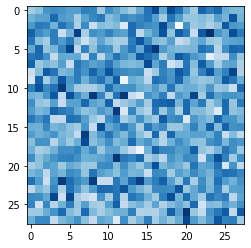

In [72]:
G=Generator()
#cuda
G.to(device)

output=G.forward(generate_random_seed(100))
img=output.detach().cpu().numpy().reshape(28,28)
plt.imshow(img,interpolation='none',cmap='Blues')

In [73]:
%%time

#训练GAN
D=Discriminator()
#cuda
D.to(device)
G=Generator()
#cuda
G.to(device)

epochs=4
for epoch in range(epochs):
    print ("epoch = ", epoch + 1)
    # image_list=[]
    #训练鉴别器&生成器
    for label,image_data_tensor,target_tensor in mnist_dataset:
        #真实样本训练鉴别器
        D.train(image_data_tensor,torch.cuda.FloatTensor([1.0]))
        #生成样本训练鉴别器
        #使用detach()避免计算生成器G中的梯度:节省计算成本
        D.train(G.forward(generate_random_seed(100)).detach(),torch.cuda.FloatTensor([0.0]))
        #训练生成器
        G.train(D,generate_random_seed(100),torch.cuda.FloatTensor([1.0]))
        # #每10000次记录图像
        # if (i%1000==0):
        #     image_list.append(G.forward(generate_random(1)).detach().numpy())
        pass






counter= 10000
counter= 20000
counter= 30000
counter= 40000
counter= 50000
counter= 60000
counter= 70000
counter= 80000
counter= 90000
counter= 100000
counter= 110000
counter= 120000
counter= 130000
counter= 140000
counter= 150000
counter= 160000
counter= 170000
counter= 180000
counter= 190000
counter= 200000
counter= 210000
counter= 220000
counter= 230000
counter= 240000
counter= 250000
counter= 260000
counter= 270000
counter= 280000
counter= 290000
counter= 300000
counter= 310000
counter= 320000
counter= 330000
counter= 340000
counter= 350000
counter= 360000
counter= 370000
counter= 380000
counter= 390000
counter= 400000
counter= 410000
counter= 420000
counter= 430000
counter= 440000
counter= 450000
counter= 460000
counter= 470000
counter= 480000
CPU times: total: 1h 48min 42s
Wall time: 27min 31s


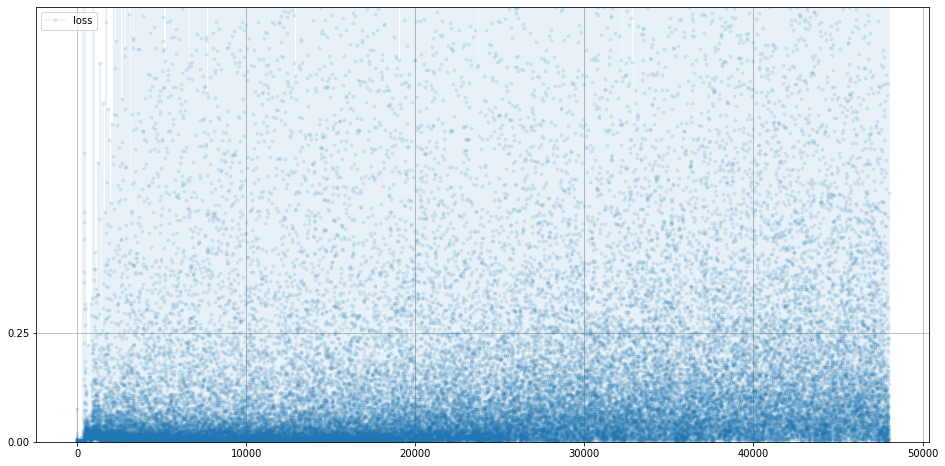

In [75]:
#鉴别器训练进展
D.plot_progress()

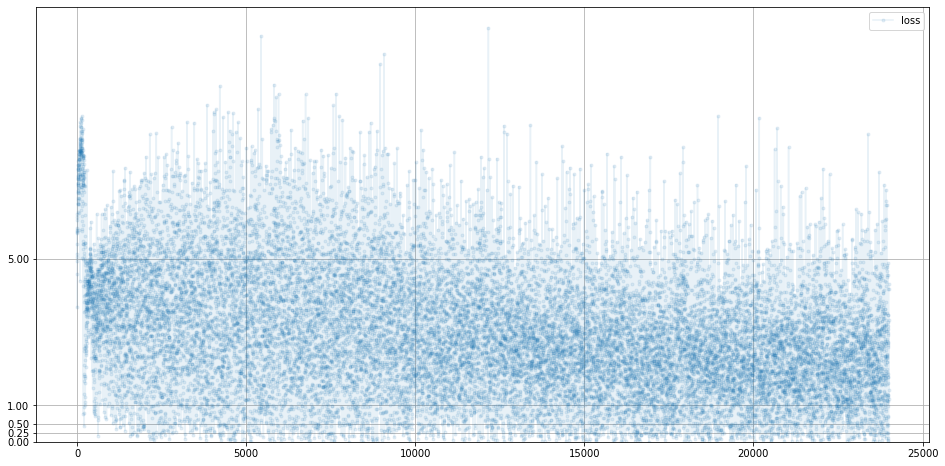

In [76]:
#生成器训练进展 ln2=0.693趋于稳定
G.plot_progress()

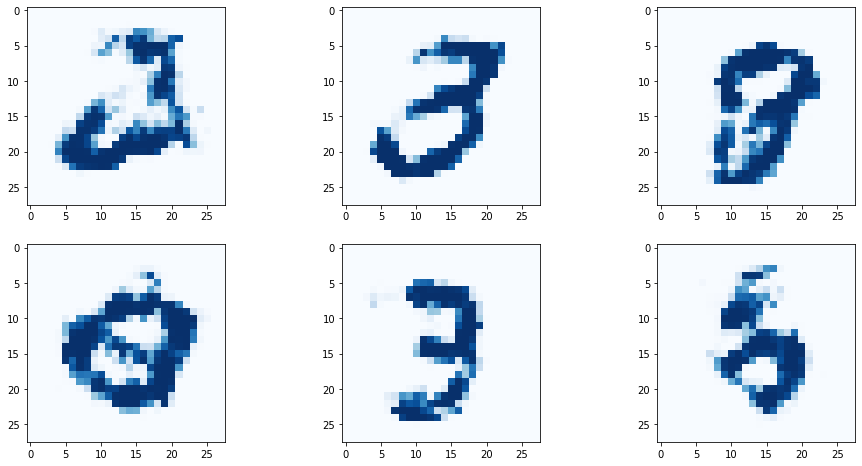

In [77]:
f,axarr=plt.subplots(2,3,figsize=(16,8))
for i in range(2):
    for j in range(3):
        output=G.forward(generate_random_seed(100))
        img=output.detach().cpu().numpy().reshape(28,28)
        axarr[i,j].imshow(img,interpolation='none',cmap='Blues')
        pass
    pass

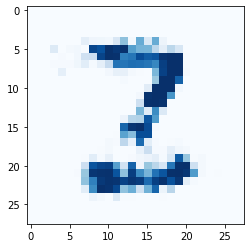

In [78]:
#种子
seed1=generate_random_seed(100)
out1=G.forward(seed1)
img1=out1.detach().numpy().reshape(28,28)
plt.imshow(img1,interpolation='none',cmap='Blues')

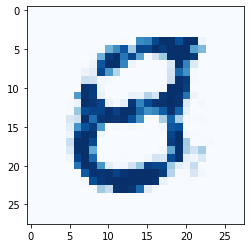

In [79]:
seed2 = generate_random_seed(100)
out2 = G.forward(seed2)
img2 = out2.detach().numpy().reshape(28,28)
plt.imshow(img2, interpolation='none', cmap='Blues')

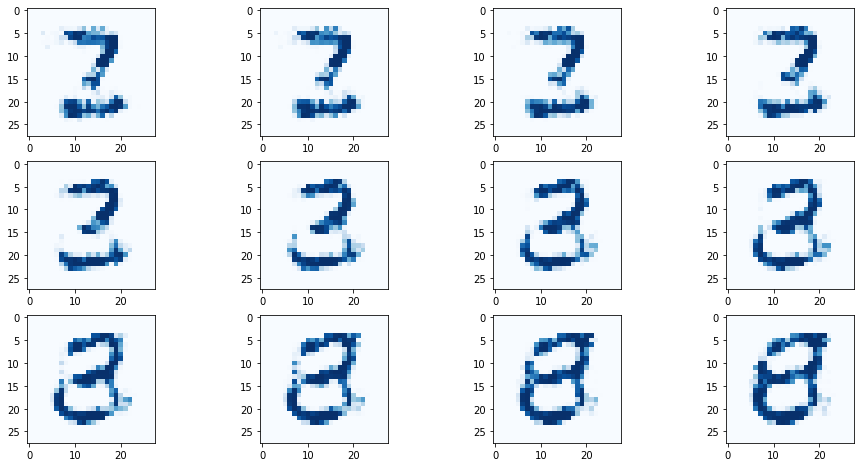

In [80]:
# plot several outputs from the trained generator

count = 0

# plot a 3 column, 2 row array of generated images
f, axarr = plt.subplots(3,4, figsize=(16,8))
for i in range(3):
    for j in range(4):
        seed = seed1 + (seed2 - seed1)/11 * count
        output = G.forward(seed)
        img = output.detach().numpy().reshape(28,28)
        axarr[i,j].imshow(img, interpolation='none', cmap='Blues')
        count = count + 1
        pass
    pass

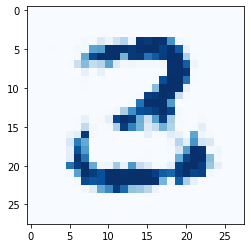

In [82]:
# sum of seeds

seed3 = seed1 + seed2
out3 = G.forward(seed3)
img3 = out3.detach().numpy().reshape(28,28)
plt.imshow(img3, interpolation='none', cmap='Blues')

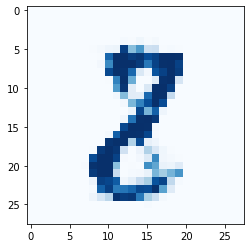

In [83]:
# difference of seeds

seed4 = seed1 - seed2
out4 = G.forward(seed4)
img4 = out4.detach().numpy().reshape(28,28)
plt.imshow(img4, interpolation='none', cmap='Blues')